In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
from avcv.all import show, time

In [3]:
# Assuming vae, unet, scheduler, and clip are already defined
import torch
from torch import autocast
from tqdm.auto import tqdm
from diffusers import StableDiffusionPipeline

# Set device
# Import necessary libraries
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import requests
from io import BytesIO


device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
# Load the pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path)#, torch_dtype=torch.float16)
pipe = pipe.to(device)

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/anhvth5/miniconda3/envs/py39-ac/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/anhvth5/miniconda3/envs/py39-ac/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/anhvth5/miniconda3/envs/py39-ac/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [1]:
scheduler = pipe.scheduler

NameError: name 'pipe' is not defined

In [5]:
# Move models to device
vae = pipe.vae.to(device)
unet = pipe.unet.to(device)

In [6]:
tokenizer = pipe.tokenizer
text_model = pipe.text_encoder.to(device)

### Input

In [7]:
prompt = "An image with a cat inside"
num_inference_steps=50
guidance_scale=7.5
height=512
width=512
seed = 1
num_images_per_prompt = 1

In [8]:
# g = torch.Generator(seed)
torch.manual_seed(seed)
# Step 1: Encode the prompt
f'Step 1: Prepare text embeddings'
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_model(text_input.input_ids.to(device))[0]
print(f'Text embeddings shape: {text_embeddings.shape}')

# Step 2: Create unconditioned embeddings
f'Step 2: Prepare unconditioned embeddings for classifier-free guidance'
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * 1, padding="max_length", max_length=max_length, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_model(uncond_input.input_ids.to(device))[0]
print(f'Unconditioned embeddings shape: {uncond_embeddings.shape}')

# Step 3: Concatenate embeddings
f'Step 3: Concatenate text and unconditioned embeddings'
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(f'Combined embeddings shape: {text_embeddings.shape}')

# Step 4: Prepare initial latents
f'Step 4: Prepare initial latents'
latents = torch.randn((1, unet.config.in_channels, height // 8, width // 8)).to(device)
print(f'Initial latents shape: {latents.shape}')

# Step 5: Set timesteps
f'Step 5: Set timesteps for the scheduler'
scheduler.set_timesteps(num_inference_steps)
print(f'Number of inference steps: {num_inference_steps}')

# Step 6: Denoising loop
f'Step 6: Start denoising loop'
with torch.inference_mode():
    for t in tqdm(scheduler.timesteps):
        print(f'-- {t=} --')
        # Step 6a: Prepare latent model input
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        print(f'Latent model input shape: {latent_model_input.shape}')
    
        # Step 6b: Predict noise
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        print(f'Noise prediction shape: {noise_pred.shape}')
    
        # Step 6c: Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        text_direction = guidance_scale*(noise_pred_text - noise_pred_uncond)
        noise_pred = noise_pred_uncond + text_direction
        
        print(f'Guided noise prediction shape: {noise_pred.shape}')
    
        # Step 6d: Update latents
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        print(f'Updated latents shape: {latents.shape}')
    
# Step 7: Decode latents to image
f'Step 7: Decode latents to image'
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
print(f'Decoded image shape: {image.shape}')

# Step 8: Post-process image
f'Step 8: Post-process image'
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0]
print(f'Final image shape: {image.shape}')


Text embeddings shape: torch.Size([1, 77, 768])
Unconditioned embeddings shape: torch.Size([1, 77, 768])
Combined embeddings shape: torch.Size([2, 77, 768])
Initial latents shape: torch.Size([1, 4, 64, 64])
Number of inference steps: 50


  0%|          | 0/51 [00:00<?, ?it/s]

-- t=tensor(981) --
Latent model input shape: torch.Size([2, 4, 64, 64])
Noise prediction shape: torch.Size([2, 4, 64, 64])
Guided noise prediction shape: torch.Size([1, 4, 64, 64])
Updated latents shape: torch.Size([1, 4, 64, 64])
-- t=tensor(961) --
Latent model input shape: torch.Size([2, 4, 64, 64])
Noise prediction shape: torch.Size([2, 4, 64, 64])
Guided noise prediction shape: torch.Size([1, 4, 64, 64])
Updated latents shape: torch.Size([1, 4, 64, 64])
-- t=tensor(961) --
Latent model input shape: torch.Size([2, 4, 64, 64])
Noise prediction shape: torch.Size([2, 4, 64, 64])
Guided noise prediction shape: torch.Size([1, 4, 64, 64])
Updated latents shape: torch.Size([1, 4, 64, 64])
-- t=tensor(941) --
Latent model input shape: torch.Size([2, 4, 64, 64])
Noise prediction shape: torch.Size([2, 4, 64, 64])
Guided noise prediction shape: torch.Size([1, 4, 64, 64])
Updated latents shape: torch.Size([1, 4, 64, 64])
-- t=tensor(921) --
Latent model input shape: torch.Size([2, 4, 64, 64])

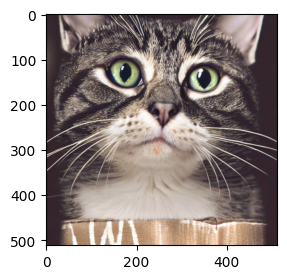

In [9]:
show(image, size=3, dpi=100)

In [10]:
from PIL import Image
Image.fromarray(image).save('test.png')

### To latents then manipulate

  0%|          | 0/11 [00:00<?, ?it/s]

Decoded image shape: torch.Size([1, 3, 512, 512])
Final image shape: (512, 512, 3)


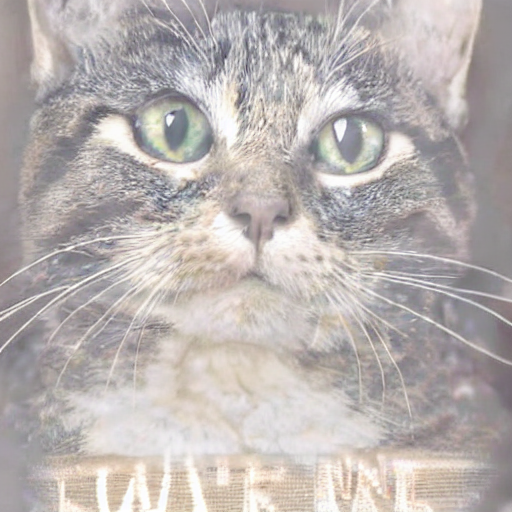

In [14]:
# Import necessary libraries
from PIL import Image
import numpy as np
import torch
from tqdm.notebook import tqdm

# Assuming you have already imported and set up the required models and tokenizer

# Text embedding
def get_text_embeddings(text):
    text_input = tokenizer(text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_model(text_input.input_ids.to(device))[0]
    return text_embeddings

# Image preprocessing
def preprocess_image(image_path, width, height):
    input_image = Image.open(image_path).convert("RGB")
    input_image = input_image.resize((width, height))
    input_image = np.array(input_image) / 255.0
    input_image = torch.from_numpy(input_image).float().permute(2, 0, 1).unsqueeze(0).to(device)
    return input_image

# Latent space encoding
def encode_to_latent(input_image, num_inference_steps, strength):
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps, num_inference_steps = pipe.get_timesteps(num_inference_steps, strength, device)
    generator = torch.Generator(device=device)
    with torch.no_grad():
        latents = vae.encode(input_image).latent_dist.sample(generator=generator) * vae.config.scaling_factor
        noise = torch.randn_like(latents)
        latents = scheduler.add_noise(latents, noise, timesteps[0])
    return latents, timesteps

# Inference steps
def inference_steps(latents, timesteps, text_embeddings):
    for t in tqdm(timesteps):
        noise_pred = pipe.unet(latents, t, encoder_hidden_states=text_embeddings).sample
        latents = pipe.scheduler.step(noise_pred, t, latents)['prev_sample']
    return latents

# Decode latents to image
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    return image

# Post-process image
def postprocess_image(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")[0]
    return image

# Main process
@torch.inference_mode()
def generate_image(text, image_path, width, height, num_inference_steps=25, strength=0.4):
    # Get text embeddings
    text_embeddings = get_text_embeddings(text)
    
    # Preprocess input image
    input_image = preprocess_image(image_path, width, height)
    
    # Encode to latent space
    latents, timesteps = encode_to_latent(input_image, num_inference_steps, strength)
    
    # Perform inference steps
    latents = inference_steps(latents, timesteps, text_embeddings)
    
    # Decode latents to image
    image = decode_latents(latents)
    print(f'Decoded image shape: {image.shape}')
    
    # Post-process image
    final_image = postprocess_image(image)
    print(f'Final image shape: {final_image.shape}')
    
    return Image.fromarray(final_image)

# Usage
text = "A cute, beautiful white cat, clear"
image_path = "test.png"
width, height = 512, 512  # Adjust as needed

result_image = generate_image(text, image_path, width, height)
result_image

### Diffusers pipeline

  0%|          | 0/35 [00:00<?, ?it/s]

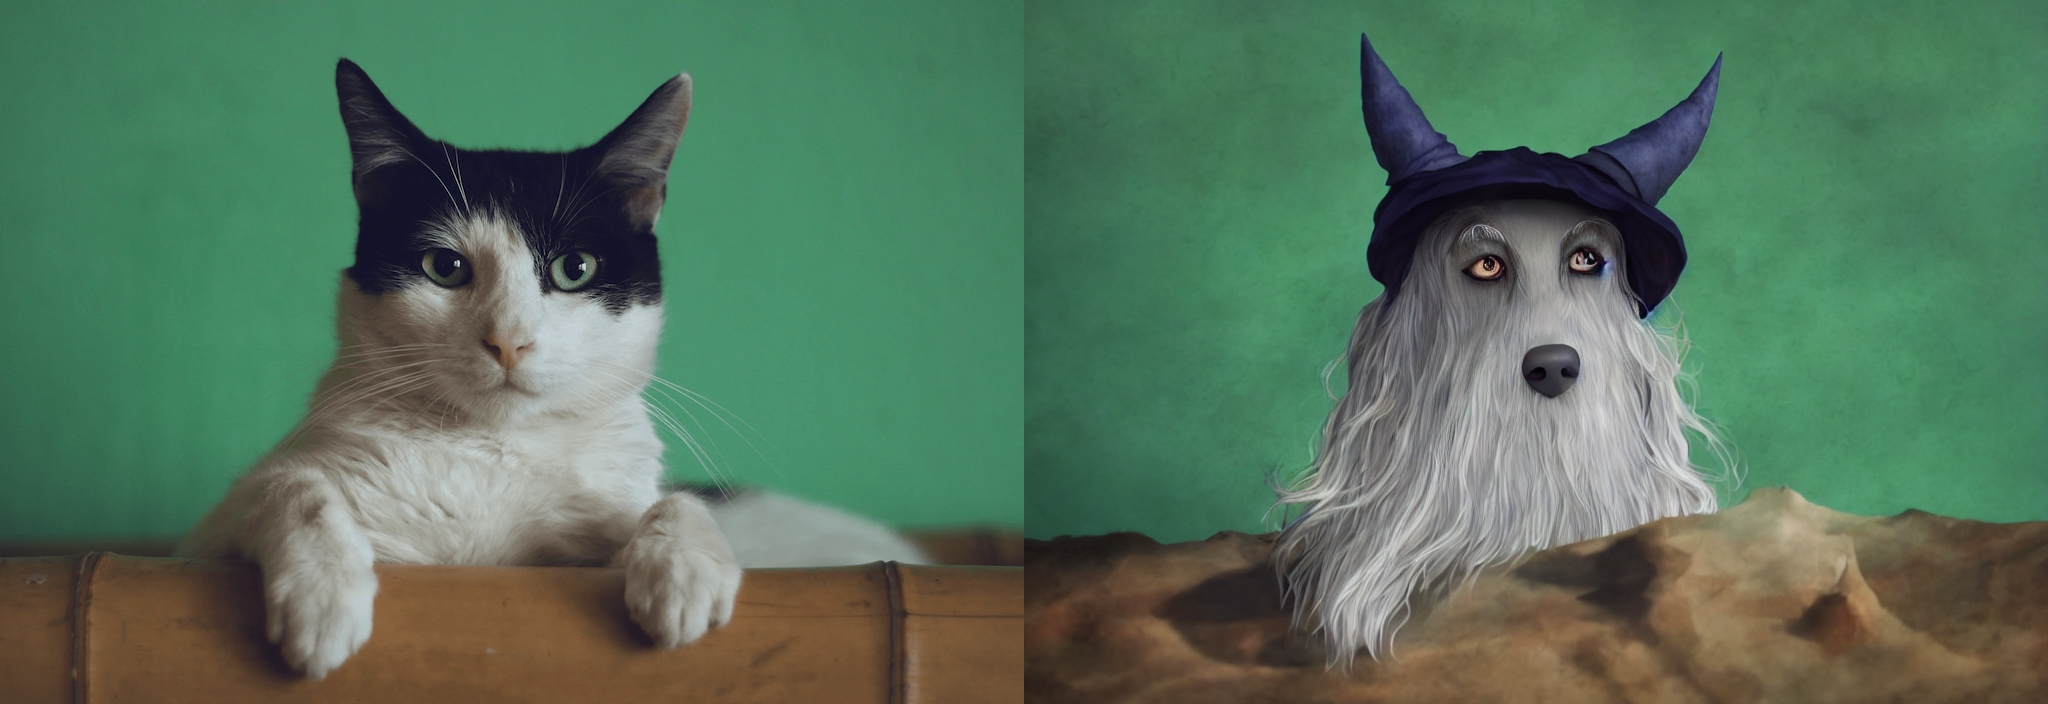

In [27]:
from diffusers.utils import load_image, make_image_grid

init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/cat.png")

prompt = "dog wizard, gandalf, lord of the rings, detailed, fantasy, cute, adorable, Pixar, Disney, 8k"
image = pipe(prompt, image=init_image, strength=0.7).images[0]
make_image_grid([init_image, image], rows=1, cols=2)

In [24]:
# pipe.to('cuda');

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

with torch.inference_mode():
    image = pipe(prompt, generator=torch.Generator(0)).images
image[0]

## SAG Pipeline

In [ ]:
from diffusers import StableDiffusionSAGPipeline, StableDiffusionPipeline

### utils function for sag

In [ ]:
F = torch.nn.functional
# Gaussian blur
def gaussian_blur_2d(img, kernel_size, sigma):
    ksize_half = (kernel_size - 1) * 0.5

    x = torch.linspace(-ksize_half, ksize_half, steps=kernel_size)

    pdf = torch.exp(-0.5 * (x / sigma).pow(2))

    x_kernel = pdf / pdf.sum()
    x_kernel = x_kernel.to(device=img.device, dtype=img.dtype)

    kernel2d = torch.mm(x_kernel[:, None], x_kernel[None, :])
    kernel2d = kernel2d.expand(img.shape[-3], 1, kernel2d.shape[0], kernel2d.shape[1])

    padding = [kernel_size // 2, kernel_size // 2, kernel_size // 2, kernel_size // 2]

    img = F.pad(img, padding, mode="reflect")
    img = F.conv2d(img, kernel2d, groups=img.shape[-3])

    return img


def sag_masking(original_latents, attn_map, map_size, t, eps, unet, scheduler):
    bh, hw1, hw2 = attn_map.shape
    b, latent_channel, latent_h, latent_w = original_latents.shape
    h = unet.config.attention_head_dim
    if isinstance(h, list):
        h = h[-1]

    attn_map = attn_map.reshape(b, h, hw1, hw2)
    attn_mask = attn_map.mean(1, keepdim=False).sum(1, keepdim=False) > 1.0
    attn_mask = (
        attn_mask.reshape(b, map_size[0], map_size[1])
        .unsqueeze(1)
        .repeat(1, latent_channel, 1, 1)
        .type(attn_map.dtype)
    )
    attn_mask = F.interpolate(attn_mask, (latent_h, latent_w))

    degraded_latents = gaussian_blur_2d(original_latents, kernel_size=9, sigma=1.0)
    degraded_latents = degraded_latents * attn_mask + original_latents * (1 - attn_mask)

    degraded_latents = scheduler.add_noise(degraded_latents, noise=eps, timesteps=t)

    return degraded_latents


#     return pred_original_sample
def pred_x0(sample, noise_pred_uncond, timestep, scheduler):
    alpha_t = scheduler.alphas_cumprod[timestep]
    beta_t = 1 -alpha_t
    
    scaled_predicted_noise = (beta_t**0.5)*noise_pred_uncond
    scalling_factor = (alpha_t)**0.5
    return (sample - scaled_predicted_noise)/scalling_factor

def pred_epsilon(sample, model_output, timestep, scheduler):
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    beta_prod_t = 1 - alpha_prod_t
    
    if scheduler.config.prediction_type == "epsilon":
        pred_eps = model_output
    elif scheduler.config.prediction_type == "sample":
        pred_eps = (sample - (alpha_prod_t**0.5) * model_output) / (beta_prod_t**0.5)
    elif scheduler.config.prediction_type == "v_prediction":
        pred_eps = (beta_prod_t**0.5) * sample + (alpha_prod_t**0.5) * model_output
    else:
        raise ValueError(f"prediction_type given as {scheduler.config.prediction_type} must be one of `epsilon`, `sample`, or `v_prediction`")

    return pred_eps


### visualize

In [ ]:

def decode_latent_and_visualize(pred_x0, timeout=0.5):
    latents = 1 / 0.18215 * pred_x0
    with torch.no_grad():
        image = vae.decode(latents).sample
    print(f'Decoded image shape: {image.shape}')
    
    # Step 8: Post-process image
    f'Step 8: Post-process image'
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")[0]
    print(f'Final image shape: {image.shape}')
    show(image, dpi=100, size=3)
    # time.sleep(timeout)

In [ ]:
# prompt = "A boy walking on beautiful beach, a colorful image"
# negative_prompt = "wave, boy, green shirt"
num_inference_steps=50
guidance_scale=7.5
height=512
width=512
seed = 0
sag_scale = .5

In [ ]:
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_sag import StableDiffusionSAGPipeline, CrossAttnStoreProcessor

# processor to store attention
store_processor = CrossAttnStoreProcessor()
unet.mid_block.attentions[0].transformer_blocks[0].attn1.processor = store_processor

map_size = None

def get_map_size(module, input, output):
    global map_size
    map_size = output[0].shape[-2:]

### Mainloop

In [ ]:
from PIL import Image
image = Image.open('image.png')
image

In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np

def preprocess(image):
    np_image = np.array(image)/127.5 - 1
    return torch.tensor(np_image)[None].permute([0, 3,1,2]).float()

In [ ]:
torch.manual_seed(seed)
# Step 1: Encode the prompt
f'Step 1: Prepare text embeddings'
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_model(text_input.input_ids.to(device))[0]
print(f'Text embeddings shape: {text_embeddings.shape}')

# Step 2: Create unconditioned embeddings
f'Step 2: Prepare unconditioned embeddings for classifier-free guidance'
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * 1, padding="max_length", max_length=max_length, return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_model(uncond_input.input_ids.to(device))[0]
print(f'Unconditioned embeddings shape: {uncond_embeddings.shape}')

# Step 3: Concatenate embeddings
f'Step 3: Concatenate text and unconditioned embeddings'
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(f'Combined embeddings shape: {text_embeddings.shape}')

# Step 4: Prepare initial latents
f'Step 4: Prepare initial latents'

# latents = torch.randn((1, unet.config.in_channels, height // 8, width // 8)).to(device)
with torch.no_grad():
    # image = preprocess(Image.open('image.png')).to(device)
    # latents = vae.encoder(image)[:,:4]
    # latents = (latents - latents.mean()) / latents.std()
    latents = torch.randn((1, unet.config.in_channels, height // 8, width // 8)).to(device)

print(f'Initial latents shape: {latents.shape}')

# Step 5: Set timesteps
f'Step 5: Set timesteps for the scheduler'
scheduler.set_timesteps(num_inference_steps)
print(f'Number of inference steps: {num_inference_steps}')

# Step 6: Denoising loop
f'Step 6: Start denoising loop'
attention_module = unet.mid_block.attentions[0]
with attention_module.register_forward_hook(get_map_size), torch.inference_mode():
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        # if i < 20:continue
        print(f'-- {t=} --')
        # Step 6a: Prepare latent model input
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        print(f'Latent model input shape: {latent_model_input.shape}')
    
        # Step 6b: Predict noise
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        print(f'Noise prediction shape: {noise_pred.shape}')
    
        # Step 6c: Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        
        text_direction = guidance_scale*(noise_pred_text - noise_pred_uncond)
        
        noise_pred = noise_pred_uncond + text_direction
        
        # Apply SAG
        if 1:
            attn_map = store_processor.attention_probs
            x0 = pred_x0(latents, noise_pred_uncond, t, scheduler)
            
            uncond_attn, cond_attn = store_processor.attention_probs.chunk(2)
            
            epsilon = pred_epsilon(latents, noise_pred_uncond, t, scheduler)
            
            
            uncond_degraded_latents = sag_masking(x0, uncond_attn, map_size, t, epsilon, unet, scheduler)
            decode_latent_and_visualize(uncond_degraded_latents)
            noise_degraded_pred_uncondition = unet(uncond_degraded_latents, t, encoder_hidden_states=uncond_embeddings).sample

            undegraded_vector = sag_scale * (noise_pred_uncond - noise_degraded_pred_uncondition)
            noise_pred += undegraded_vector
            
        print(f'Guided noise prediction shape: {noise_pred.shape}')
    
        # Step 6d: Update latents
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        print(f'Updated latents shape: {latents.shape}')
        
    latents = 1 / 0.18215 * latents
    
# Step 7: Decode latents to image
with torch.no_grad():
    image = vae.decode(latents).sample
print(f'Decoded image shape: {image.shape}')

# Step 8: Post-process image
f'Step 8: Post-process image'
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")[0]
print(f'Final image shape: {image.shape}')

In [ ]:
show(image, dpi=100, size=5)

# HF SAG PIPELINE 

In [ ]:
import torch
from diffusers import StableDiffusionSAGPipeline
from accelerate.utils import set_seed

pipe = StableDiffusionSAGPipeline.from_pretrained(model_id,  torch_dtype=torch.float16)
pipe = pipe.to("cuda")



seed = 0
# prompt = "."
guidance_scale = 7.5
num_images_per_prompt = 1

sag_scale = 1.0

In [ ]:
sag_scale = 1
set_seed(seed)
images = pipe(
    prompt, num_images_per_prompt=num_images_per_prompt, guidance_scale=guidance_scale, sag_scale=sag_scale
).images
images[0]

In [ ]:
sag_scale = 0.0
set_seed(seed)
images = pipe(
    prompt, num_images_per_prompt=num_images_per_prompt, guidance_scale=guidance_scale, sag_scale=sag_scale
).images
images[0]